## Simpson Character Classifier

The dataset are accessible through
https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset


Aim: Build a model that could accurately identify character's name inside an image. Challenges arise in this project mainly comes from the randomness of the dataset where for each character, they are presented in a variety of situations with different backgrounds, different angles, etc.

In [1]:
import tensorflow as tf 
import numpy as np            
import matplotlib.pyplot as plt         
import os 
import copy 
import itertools 
from tensorflow import keras 
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.preprocessing.image import ImageDataGenerator             
from PIL import Image             
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

In [2]:
# Connect Drive to Colab
try:
  from google.colab import drive
  drive.mount('/content/drive')
  has_colab=True
except ImportError:
  has_colab=False

if has_colab:
  import os
  default_path='/content/drive/MyDrive/Detecting_Character'
  os.chdir(default_path)
else:
  os.chdir('/..')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data

In [3]:
train_path = '/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/simpsons_dataset/'
test_path = '/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/kaggle_simpson_testset/kaggle_simpson_testset/'

In [4]:
os.chdir(train_path)
num_classes = len(os.listdir(train_path)) # How many classes are there?
characters = sorted(os.listdir(train_path)) # List of characters
print(num_classes) 

20


### Loading Training Set

In [5]:
img_size = (112,112)
# data = []
# labels = []

# for i in characters:     
#     path = train_path + '/' + i
#     images = sorted(os.listdir(path))

#     for file in images:   
#         try:
#             image = Image.open(path + '/' + file)
#             image = image.resize(img_size)   
#             image = np.array(image)
#             data.append(image)
#             labels.append(i)        
#         except:
#             print(f'Error loading image, character: {i}, file: {file}')

# data = np.array(data)
# labels = np.array(labels)

# Saving the numpy arrays 
# np.save('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/X_train_set.npy', data)
# np.save('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/y_train_set.npy', labels)
     

In [6]:
data = np.load('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/X_train_set.npy')
labels = np.load('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/y_train_set.npy')
print(data.shape)
print(labels.shape)

(19548, 112, 112, 3)
(19548,)


In [7]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=42)
del data # Remove this to save RAM
del labels # Remove this to save RAM

In [8]:
# Checking Dimensions
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(13683, 112, 112, 3)
(13683,)
(5865, 112, 112, 3)
(5865,)


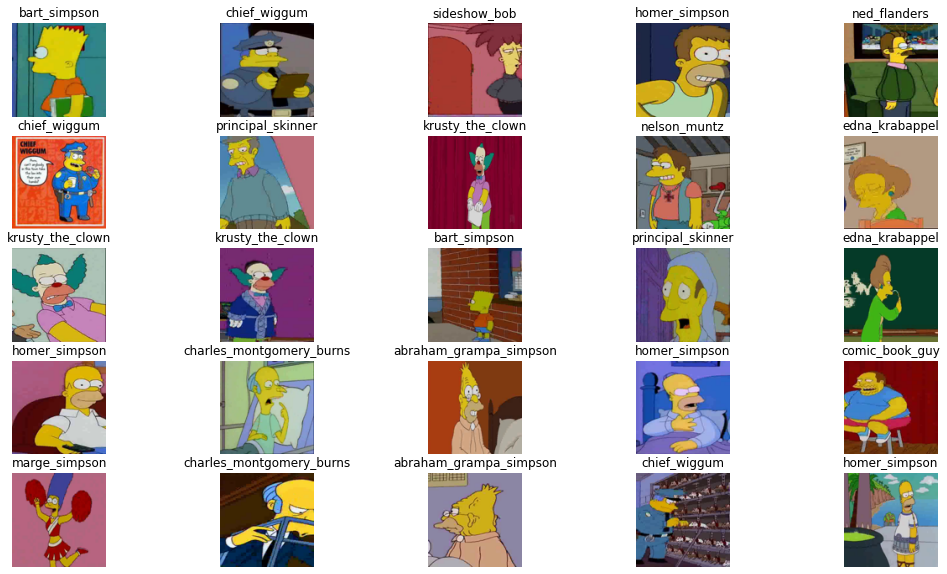

In [9]:
# Plotting Image
fig = plt.figure(figsize=(18, 10))
cols = 5
rows = 5
for i in range(1, cols*rows + 1):
    img = X_train[i,:,:,:]
    lb = y_train[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(lb)
    plt.axis('off')
plt.show()

### Loading Test Set

In [10]:
# test_data = []
# test_labels = []

# for i in sorted(os.listdir(test_path)):
#     path = test_path + '/' + i
#     image = Image.open(path)
#     image = image.resize(img_size)
#     image = np.array(image)
#     test_data.append(image)
#     split_label = i.split('_') 
#     label = '_'.join(split_label[:-1]) 
#     test_labels.append(label) 

# test_data = np.array(test_data)
# test_labels = np.array(test_labels)

In [11]:
# Saving the numpy arrays 
# np.save('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/X_test_set.npy', test_data)
# np.save('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/y_test_set.npy', test_labels)
# del test_data # Remove this to save RAM
# del test_labels # Remove this to save RAM

In [9]:
# Load test set
X_test = np.load('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/X_test_set.npy')
y_test = np.load('/content/drive/MyDrive/Detecting_Character/detecting_character_dataset/y_test_set.npy')
print(X_test.shape)
print(y_test.shape)

(990, 112, 112, 3)
(990,)


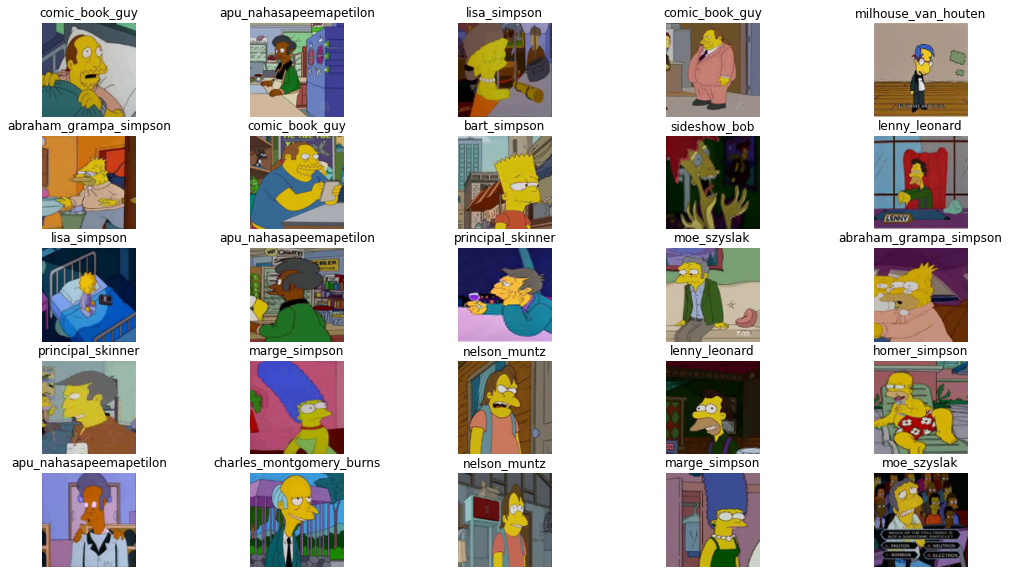

In [13]:
# Plotting test set images

fig = plt.figure(figsize=(18, 10))
cols = 5
rows = 5
for i in range(1, cols*rows + 1):
    random_number = np.random.randint(990) # To index random images
    img = X_test[random_number,:,:,:]
    lb = y_test[random_number]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(lb)
    plt.axis('off')
plt.show()

## Data Preprocessing 

### Label Processing

Labels in the dataset are categorical while model needs the label to be a number. Solution for this is to do one-hot encoding to represent the classes. One-hot encoding was done because it avoids order of classes. LabelEncoder from Sklearn and to_categorical from Keras was used since it helps us to encode these labels for us.

In [10]:
classes = sorted(list(set(characters)))
print("Test set labels", np.array(classes).shape, "\n")
classes

Test set labels (20,) 



['abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'comic_book_guy',
 'edna_krabappel',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lisa_simpson',
 'marge_simpson',
 'mayor_quimby',
 'milhouse_van_houten',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'principal_skinner',
 'sideshow_bob']

In [11]:
def one_hot_classes(y, names):
  encoder = LabelEncoder()
  int_class = encoder.fit_transform(y)
  output = to_categorical(int_class, num_classes=len(names))
  return output

In [12]:
y_train_hot = one_hot_classes(y_train, classes)
y_val_hot = one_hot_classes(y_val, classes)
y_test_hot = one_hot_classes(y_test, classes)

In [13]:
# Normalize Data
X_train = (X_train/255).astype(np.float32)
X_validation = (X_val/255).astype(np.float32)
X_test = (X_test/255).astype(np.float32)

## Building Deep Learning Models

### CNN Baseline Model


In [18]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, 5, activation='relu', padding='valid', input_shape=X_train[0].shape),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='valid'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 108, 108, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

## Preventing Overfitting
Early stopping was done to reduce the chance for the model to overfit the training data.

In [20]:
earlystopping = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 monitor='val_accuracy', 
                                                 mode='max')
baseline_model = model.fit(X_train, y_train_hot, 
              validation_data=(X_validation, y_val_hot), epochs=10, 
              batch_size=64, callbacks=[earlystopping])

Epoch 1/10
214/214 [==============================] - 10s 33ms/step - loss: 2.7034 - accuracy: 0.1712 - val_loss: 2.3142 - val_accuracy: 0.2672
Epoch 2/10
214/214 [==============================] - 5s 24ms/step - loss: 2.0521 - accuracy: 0.3571 - val_loss: 1.5597 - val_accuracy: 0.5223
Epoch 3/10
214/214 [==============================] - 5s 24ms/step - loss: 1.4776 - accuracy: 0.5313 - val_loss: 1.1573 - val_accuracy: 0.6375
Epoch 4/10
214/214 [==============================] - 6s 29ms/step - loss: 1.1254 - accuracy: 0.6464 - val_loss: 0.8440 - val_accuracy: 0.7398
Epoch 5/10
214/214 [==============================] - 5s 25ms/step - loss: 0.8499 - accuracy: 0.7327 - val_loss: 0.8300 - val_accuracy: 0.7526
Epoch 6/10
214/214 [==============================] - 5s 25ms/step - loss: 0.6896 - accuracy: 0.7875 - val_loss: 0.6797 - val_accuracy: 0.7993
Epoch 7/10
214/214 [==============================] - 5s 24ms/step - loss: 0.5587 - accuracy: 0.8307 - val_loss: 0.5866 - val_accuracy: 0.831

## Baseline Model Evaluation

In [21]:
model.evaluate(X_train, y_train_hot)

428/428 [==============================] - 3s 7ms/step - loss: 0.1987 - accuracy: 0.9406


[0.1986970156431198, 0.9405832290649414]

In [22]:
model.evaluate(X_validation, y_val_hot)

184/184 [==============================] - 1s 8ms/step - loss: 0.5917 - accuracy: 0.8503


[0.5916858315467834, 0.8502984046936035]

In [23]:
model.evaluate(X_test, y_test_hot)

31/31 [==============================] - 1s 11ms/step - loss: 0.3057 - accuracy: 0.9162


[0.305743008852005, 0.9161615967750549]

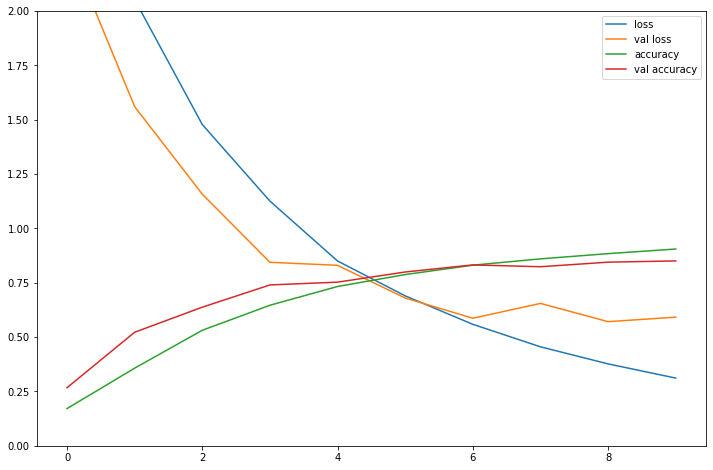

In [25]:
plt.figure(figsize=(12,8))
plt.plot(baseline_model.history['loss'], label = 'loss')
plt.plot(baseline_model.history['val_loss'], label = 'val loss')
plt.plot(baseline_model.history['accuracy'], label = 'accuracy')
plt.plot(baseline_model.history['val_accuracy'], label = 'val accuracy')
plt.gca().set_ylim(0,2)
plt.legend()

## Analyzing Model Predictions

In [26]:
y_pred = model.predict(X_test)

31/31 [==============================] - 0s 6ms/step


In [28]:
# Function to take classes with the largest probability for each prediction given
def label_translator(class_names, y_pred):
    '''Returns a list of the predicted 
    results translated into the original class names'''

    y_copy = copy.deepcopy(y_pred)

    # Creating one hot encoded arrays out of the probability results output
    masked = []
    for prediction in y_copy:
        # Making the greatest probability 1 and the rest 0 with a mask
        prediction[np.argmax(prediction)] = 1
        masked.append((prediction >= 1).astype('int32'))

    # One hot encoding the characters array for reverse translation
    class_names_hot = one_hot_classes(class_names, class_names)

    # Transforming each one hot encoded output into a string to be used as a key
    stringed_hot = [str(onehot.astype('int32')) for onehot in class_names_hot]
    labels_dict = dict(zip(stringed_hot, class_names))
     
    return [labels_dict[str(array)] for array in masked]
     

In [30]:
# Confusion matrix comparing the predictions and the actual test labels
y_test_predicted = label_translator(classes, y_pred)
confusion_matrix = confusion_matrix(y_test, y_test_predicted)

In [31]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    '''This function prints and plots the confusion matrix.'''

    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

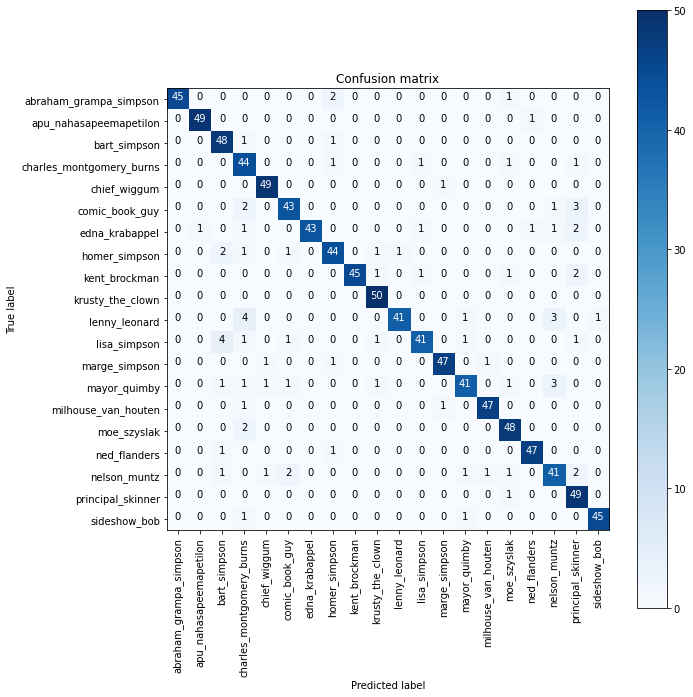

In [33]:
plot_confusion_matrix(cm = confusion_matrix, classes = classes)

In [34]:
print(classification_report(y_test, y_test_predicted))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.94      0.97        48
  apu_nahasapeemapetilon       0.98      0.98      0.98        50
            bart_simpson       0.84      0.96      0.90        50
charles_montgomery_burns       0.75      0.92      0.82        48
            chief_wiggum       0.94      0.98      0.96        50
          comic_book_guy       0.90      0.88      0.89        49
          edna_krabappel       1.00      0.86      0.92        50
           homer_simpson       0.88      0.88      0.88        50
           kent_brockman       1.00      0.90      0.95        50
        krusty_the_clown       0.93      1.00      0.96        50
           lenny_leonard       0.98      0.82      0.89        50
            lisa_simpson       0.93      0.82      0.87        50
           marge_simpson       0.96      0.94      0.95        50
            mayor_quimby       0.91      0.82      0.86        50
     milh

In [35]:
# Saving model
# model.save('/content/drive/MyDrive/Detecting_Character/baseline_model.h5')

## VGG16

In [14]:
# We import the model using keras
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=[112,112,3],
    weights='imagenet',
    include_top=False)

In [15]:
## Freeze trained weights
vgg16.trainable = False

In [16]:
tail = keras.layers.Flatten()(vgg16.output)
tail = keras.layers.Dense(128, activation='relu')(tail)
tail = keras.layers.Dropout(0.5)(tail)
tail = keras.layers.Dense(64, activation='relu')(tail)
tail = keras.layers.Dense(num_classes, activation='softmax')(tail)

In [17]:
model_vgg16 = tf.keras.models.Model(inputs=vgg16.input, outputs=tail)
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0     

In [18]:
model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [20]:
earlystopping = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 monitor='val_accuracy', 
                                                 mode='max')
batch_size = 32
steps_per_epoch = X_train.shape[0] // batch_size
trained_vgg16 = model_vgg16.fit(X_train, y_train_hot, steps_per_epoch=steps_per_epoch, epochs=10, 
                        validation_data=(X_validation, y_val_hot), callbacks=[earlystopping])

Epoch 1/10
427/427 [==============================] - 40s 76ms/step - loss: 2.4103 - accuracy: 0.2634 - val_loss: 1.6921 - val_accuracy: 0.5277
Epoch 2/10
427/427 [==============================] - 30s 70ms/step - loss: 1.8332 - accuracy: 0.4419 - val_loss: 1.3464 - val_accuracy: 0.6426
Epoch 3/10
427/427 [==============================] - 33s 77ms/step - loss: 1.5620 - accuracy: 0.5250 - val_loss: 1.2383 - val_accuracy: 0.6687
Epoch 4/10
427/427 [==============================] - 30s 71ms/step - loss: 1.4342 - accuracy: 0.5577 - val_loss: 1.1451 - val_accuracy: 0.6725
Epoch 5/10
427/427 [==============================] - 31s 72ms/step - loss: 1.3209 - accuracy: 0.5879 - val_loss: 1.0786 - val_accuracy: 0.6967
Epoch 6/10
427/427 [==============================] - 31s 73ms/step - loss: 1.2311 - accuracy: 0.6195 - val_loss: 1.0596 - val_accuracy: 0.7008
Epoch 7/10
427/427 [==============================] - 31s 73ms/step - loss: 1.1804 - accuracy: 0.6293 - val_loss: 1.0275 - val_accuracy:

427/427 [==============================] - 25s 59ms/step - loss: 1.0493 - accuracy: 0.6615 - val_loss: 1.0356 - val_accuracy: 0.7074


In [22]:
# Saving Model
# model_vgg16.save('/content/drive/MyDrive/Detecting_Character/model_vgg16.h5')

In [21]:
model_vgg16.evaluate(X_train, y_train_hot)

428/428 [==============================] - 18s 43ms/step - loss: 0.5441 - accuracy: 0.8495


[0.5441115498542786, 0.849521279335022]

In [23]:
model_vgg16.evaluate(X_validation, y_val_hot)

184/184 [==============================] - 8s 43ms/step - loss: 1.0356 - accuracy: 0.7074


[1.0356276035308838, 0.7074168920516968]

In [24]:
model_vgg16.evaluate(X_test, y_test_hot)

31/31 [==============================] - 2s 69ms/step - loss: 0.8643 - accuracy: 0.7444


[0.8642888069152832, 0.7444444298744202]

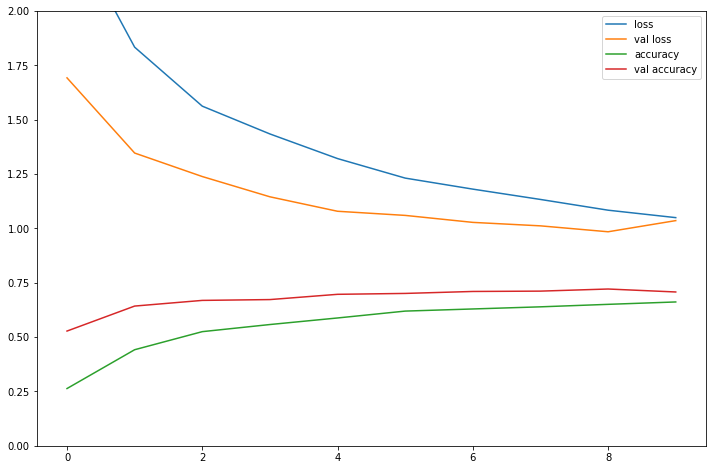

In [25]:
plt.figure(figsize=(12,8))
plt.plot(trained_vgg16.history['loss'], label = 'loss')
plt.plot(trained_vgg16.history['val_loss'], label = 'val loss')
plt.plot(trained_vgg16.history['accuracy'], label = 'accuracy')
plt.plot(trained_vgg16.history['val_accuracy'], label = 'val accuracy')
plt.gca().set_ylim(0,2)
plt.legend()